<a href="https://colab.research.google.com/github/MonitSharma/Learn-Quantum-Machine-Learning/blob/main/Galaxy_Detection_using_QNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying existence of Galaxy using Quantum Machine Learning


In the following code notebook, you'll learn how to develop a galaxy detection technique from the telescope image via Quantum Machine Learning.

-----

The accuracy of the model is $94\%$ via a quantum machine learning model from NASA image. The image is further divided into a small $16 \times 16$ image as input data. 

-----

Then the data is encoded and trained using a quantum circuit using the parameterized quantum circuit taken from the paper [Expressibilitty and entangling capability of parameterized quantum circuit for hybrid quantum-classical algorithms](https://arxiv.org/abs/1905.10876).

-----

With the high expressibility of the circuit, the model is trained and tested with Cross-Entropy as the Loss function and **L-BFGS** algorithm for optimization.


This algorithm is realized in **PyTorch** and **Qiskit** machine learning module.

## Pre-Processing of Image


Import necessary Libraries for Image pre-processing

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


## Pre-Processing Step

The below step takes the original image taken by the telescope which is around $3$ MB each. It reshapes the images in the $2463 \times 2895$ dimensions and normalized, and divided into equal $16 \times 16$ pieces. The results are named by the nymber it represents and saved in the `result` folder in grayscale.

(2463, 2895)

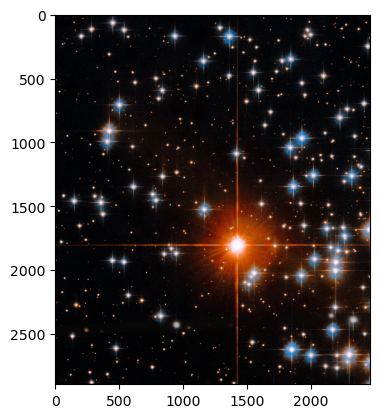

In [18]:
img = Image.open('test.jpg')
plt.imshow(img)
img.size

In [14]:
import numpy as np

data = np.random.random(23801832)  # Replace this with your actual data

# Reshape without specifying one dimension
reshaped_data = data.reshape((2463, -1))


AttributeError: 'int' object has no attribute 'reshape'

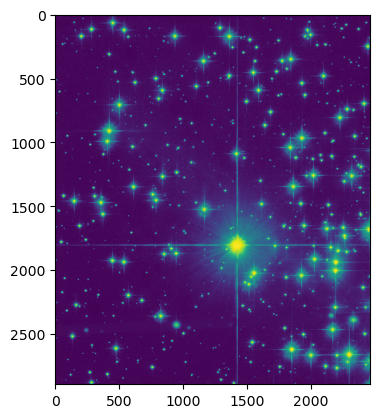

In [22]:
cut=128

img = Image.open('test.jpg').convert('L')
plt.imshow(img)
img = np.asarray(img.getdata()).reshape((2463,2895))

for i in range(2463//cut):
    for j in range(2895//cut):
        cutimg = img[i*cut:(i+1)*cut]
        cutimg = cutimg[:,list(range(j*cut,(j+1)*cut))]
        plt.imsave('result/{} {}.jpg'.format(i,j), cutimg ,cmap='gray')

## Visualize one of the Images

Here we'll visualize , one of the images from the result folder , which we will use to further train and test our data.

In [23]:

for i in range(2463//cut):
    for j in range(2895//cut):
        img16 = Image.open('result/{} {}.jpg'.format(i,j)).resize((16,16)).convert('L')
        img16 = np.asarray(img16.getdata()).reshape((16,16))
        

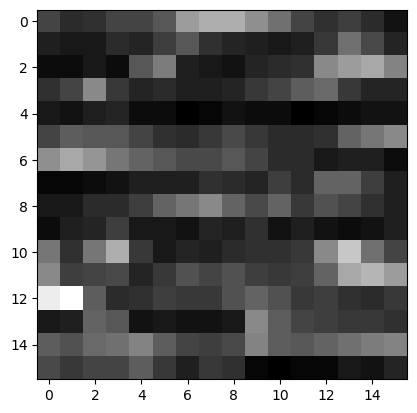

In [24]:
img16 = Image.open('result/{} {}.jpg'.format(5,1)).resize((16,16)).convert('L')
plt.imshow(img16, cmap='gray')
img16 = np.asarray(img16.getdata(), dtype=np.float64).reshape((16,16))

Ideally this is done in a separate notebook, but is shown here, just for demonstration purposes.

## Quantum Convolutional Neural Network

We will now build our QCNN to detect the Galaxy in the telescope images.



-------

We will start by importing some helper function files we made to help us train faster with less code.


This code will help us read the Images faster:

```python
import numpy as np

#Image processing
from PIL import Image

#Calling Image from the path, and file name. 
#i is the number labeling of the data
#some of the files does not have name
def callImage(i,path,name):
    x1 = Image.open(
        path+str(name)+str(i)+'.jpg').convert('L');
    y1 = np.asarray(x1.getdata(), dtype=np.float64).reshape((x1.size[1], x1.size[0]));
    y_dat1 = np.asarray(y1, dtype=np.uint8)     
    return y_dat1

#Resize image into n x n pixel
def imageResize(data,pixel):
    image = Image.fromarray(data,'L')
    image= image.resize((pixel, pixel))
    image=np.asarray(image.getdata(), dtype=np.float64).reshape((image.size[1], image.size[0]))
    image=np.asarray(image, dtype=np.uint8)    
    return image




#Making MxN partition
def imagePartition(data,M,N):
    tiles = [data[x:x+M,y:y+N] for x in range(0,data.shape[0],M) for y in range(0,data.shape[1],N)]
    return tiles

def imageBinarize(data):
    # specify a threshold 0-255
    threshold = 75
    # make all pixels < threshold black
    bidata = 1.0 * (data > threshold)
    return bidata
    
```

Save this file as `ImageRead.py`


-----

Use this file to make the Quantum Neural network:

```python
import qiskit
from qiskit import transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit import BasicAer, Aer, execute
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import *
from qiskit.quantum_info.operators import Operator
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.parameter import Parameter
import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *


nqubits=6

def normlaizeData(data):
    #Create Array of pixel value
    testdata=data
    arr_data=testdata.flatten()/max(testdata.flatten());
    encoding_data= np.array([np.round(x,6) for x in arr_data]);
    sum_const=np.sqrt(sum(encoding_data*encoding_data))
    encoding_norm=encoding_data/sum_const
    return encoding_norm

# Choose on PQC from Hannah  Sim https://arxiv.org/pdf/1905.10876.pdf circuit 15

def circuit15(qc,theta):
    #circuit 15
    #theta is list of the parameters
    #theta length is (8)L
    #L is the number of repeatation
    nqubits=6
    qr = QuantumRegister(nqubits)
    qc = QuantumCircuit(qr, name='PQC')

    count=0


    for i in range(nqubits):
        qc.ry(theta[count],i)
        count=count+1
    for i in range(nqubits-1):
        qc.cx(i,i+1)
    
    qc.cx(0,nqubits-1)
    for i in range(nqubits):
        qc.ry(theta[count],i)
        count=count+1    
    for i in range(nqubits-1):
        qc.cx(i+1,i)
    qc.cx(nqubits-1,0)
    qc.to_instruction()
    return qc
# Choose on PQC from Hannah  Sim https://arxiv.org/pdf/1905.10876.pdf circuit 15

def encoding(qc,theta,L):
    #circuit 15
    #theta is list of the parameters
    #theta length is (8)L
    #L is the number of repeatation
    nqubits=6
    qr = QuantumRegister(nqubits)
    qc = QuantumCircuit(qr, name='Embed')

    count=0
    for i in range(nqubits):
        qc.h(i)
        
    for l in range(L):
        for i in range(nqubits):
            qc.ry(theta[count],i)
            count=count+1
        for i in range(nqubits-1):
            qc.cx(i,i+1)
        
        qc.cx(nqubits-1,0)
        for i in range(nqubits):
            qc.ry(theta[count],i)
            count=count+1    
        for i in range(nqubits-1):
            qc.cx(i+1,i)
        qc.cx(0,nqubits-1)
        
    qc.to_instruction()
    return qc




# mapping the data
# mapping is taken from https://arxiv.org/pdf/2003.09887.pdf
def binary(x):
    return ('0'*(6-len('{:b}'.format(x, '#010b') ))+'{:b}'.format(x, '#010b'))
def firsttwo(x):
    return x[:2]
parity = lambda x: firsttwo(binary(x)).count('1') % 2   

```

Save this as `QNN.py`  and as you can see this file is heavily Qiskit dependent, make sure to install the latest Qiskit packages and all its necessary dependencies.




-----
-----

Import Basic python packages and the two python helper scirpts that we made to make our life easier.



In [26]:
import random
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../PyFiles')   # where the Helper files are saved
# Pull in the helper files.
from ImageRead import *  # the helper files we created to read Images
from QNN import *        # the helper file that creates the QNN


In [30]:
target_o = [1 for i in range(25)]+[0 for i in range(25)]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Loading the dataset

Load all the data files from the respective data folder and use the helper function to divide the images into smaller parts to make it easier for the QNN to read and make sense of.

In [29]:
from ImageRead import callImage, imageResize, imageBinarize  


pathY=r'../dataset/Original/galaxy/'
pathN=r'../dataset/Original/No-galaxy/'
nameN=''
nameY=''

inputY=[imageResize(callImage(i+1,pathY,nameY),16) for i in range(25)]
inputN=[imageResize(callImage(i+1,pathN,nameN),16) for i in range(25)]
input_combine = inputY+inputN

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/Original/galaxy/1.jpg'

Randomize and Re-Shuffle the data set to make it better to train.

In [ ]:
np.random.seed(0)
idx=np.array([int(i) for i in range(50)]).flatten()

np.random.shuffle(idx)

dataInput = list(input_combine[i] for i in idx )
dataTarget = list( imageBinarize(input_combine[i]) for i in idx )

data_target_o=list( target_o[i] for i in idx )

## Visualize

Display the images from the folder after all the pre-processing and ready to be feeded to the QNN.

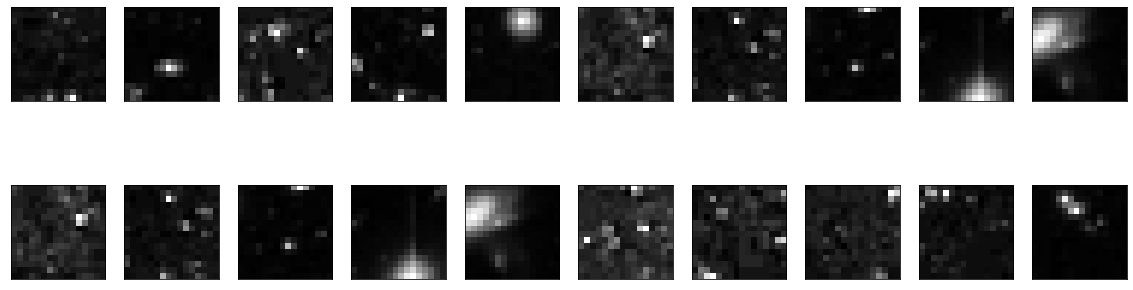

In [ ]:
n_samples_show = 10
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(20, 6))

for i in range(n_samples_show):

    axes[0,i].imshow(dataInput[i], cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[1,i].imshow(dataInput[i+5], cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])    


## The Quantum Neural Network


Import necessary files for the training.

In [ ]:
from qiskit.circuit.parameter import Parameter
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import QuantumInstance
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

# Model for LBFGS
# Combining the circuit together with CircuitQNN
np.random.seed(3)


nqubits=6
num_inputs=256
qc = QuantumCircuit(nqubits)

# Encoding
param_x=[];
for i in range(num_inputs):
    param_x.append(Parameter('x'+str(i)))
for i in range(8):
    param_x.append(np.pi/2)


feature_map = encoding(qc,param_x,22)


# Optimzing circuit PQC
param_y=[];
for i in range(nqubits*2):
    param_y.append(Parameter('θ'+str(i)))

ansatz=circuit15(qc,param_y)

qc.append(feature_map, range(nqubits))
qc.append(ansatz, range(nqubits))

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=2, quantum_instance=qi)
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)


# Learning Rate 0.05

Training the model with a Learning Rate of 0.05

In [ ]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.05)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01= [data_target_o[i] for i in range(50)]

In [ ]:
from torch import Tensor
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.46


This accuracy without applying any optimizer and just running on the first instance, as expected that the model is correct half of the time, even if you randomly classify the images you'll get the accuracy near $50\%$ , so that's what we see here.

In [ ]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.05)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01= [data_target_o[i] for i in range(50)]

In [ ]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)
optimizer.step(closure)

33.18708801269531
33.108192443847656
32.4072380065918
32.03237533569336
31.895145416259766
31.78937530517578
31.689733505249023
31.59193229675293
31.493995666503906
31.396451950073242
31.304031372070312
31.22391700744629
31.15971565246582
31.109495162963867
31.069421768188477
31.036239624023438
31.007585525512695
30.98176383972168
30.957427978515625
30.93332862854004
30.908166885375977
30.88027572631836
30.84713363647461
30.804162979125977
30.741378784179688
30.637073516845703
30.515186309814453
30.469327926635742
30.444242477416992
30.421152114868164
30.39798355102539
30.37508773803711
30.352642059326172
30.330595016479492
30.308734893798828
30.286935806274414
30.26512908935547
30.24332046508789
30.221588134765625
30.200000762939453


tensor(30.9082, grad_fn=<AddBackward0>)

In [ ]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.92


Here you can see that the accuracy goes to $92\%$ , which says that our model is good at classifying.

# Learning rate 0.06

Increasing the Learning Rate with $+0.01$ to $0.06$, we'll see how it affects the accuracy.

In [ ]:
# define optimizer and loss function
from torch import Tensor
model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.06)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01= [data_target_o[i] for i in range(50)]

y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.46


In [ ]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)
optimizer.step(closure)

33.18708801269531
33.092506408691406
32.27847671508789
31.932584762573242
31.801755905151367
31.696422576904297
31.596323013305664
31.49781036376953
31.399715423583984
31.304540634155273
31.219013214111328
31.14921760559082
31.095157623291016
31.052919387817383
31.01851463317871
30.989017486572266
30.96230697631836
30.936681747436523
30.910457611083984
30.88165283203125
30.847291946411133
30.801864624023438
30.7325382232666
30.610553741455078
30.497982025146484
30.462387084960938
30.439420700073242
30.41527557373047
30.38955307006836
30.363304138183594
30.336950302124023
30.31045150756836
30.28369903564453
30.256694793701172
30.22960662841797
30.202392578125
30.172588348388672
30.144634246826172
30.120256423950195
30.096738815307617


tensor(30.8473, grad_fn=<AddBackward0>)

In [ ]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.92


We see the accuracy drops to $92\%$ from $94\%$.

# Learning Rate 0.07

Increasing the accuracy even further by $0.01$

In [ ]:
# define optimizer and loss function
from torch import Tensor
model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.07)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01= [data_target_o[i] for i in range(50)]

y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.46


In [ ]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)
optimizer.step(closure)

33.18708801269531
33.07685089111328
32.15932846069336
31.843116760253906
31.71990394592285
31.616920471191406
31.518083572387695
31.42047691345215
31.324111938476562
31.233501434326172
31.156253814697266
31.095962524414062
31.04983901977539
31.013206481933594
30.98231315612793
30.954456329345703
30.927480697631836
30.899188995361328
30.866764068603516
30.82535743713379
30.764251708984375
30.654775619506836
30.505294799804688
30.467437744140625
30.445926666259766
30.420310974121094
30.390424728393555
30.358802795410156
30.326568603515625
30.2938232421875
30.260597229003906
30.227100372314453
30.19232749938965
30.15595245361328
30.12395477294922
30.094696044921875
30.066675186157227
30.039791107177734
30.01435661315918
29.9906005859375


tensor(30.7643, grad_fn=<AddBackward0>)

In [ ]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.92


The acciracy remained constant at $92\%$

# Test Model

Testing the model with unseen data.

In [ ]:
target_o = [1 for i in range(25)]+[0 for i in range(25)]

pathY=r'../dataset/Original/galaxy1/'
pathN=r'../dataset/Original/no-galaxy1/'
nameN=''
nameY=''
inputY=[imageResize(callImage(i+1,pathY,nameY),16) for i in range(25)]
inputN=[imageResize(callImage(i+1,pathN,nameN),16) for i in range(25)]
input_combine = inputY+inputN

np.random.seed(0)
idx=np.array([int(i) for i in range(50)]).flatten()

np.random.shuffle(idx)

dataInput = list(input_combine[i] for i in idx )
dataTarget = list( imageBinarize(input_combine[i]) for i in idx )

data_target_o=list( target_o[i] for i in idx )

Xtest= [normlaizeData(dataInput[i].flatten()) for i in range(25)]
y01test= [data_target_o[i] for i in range(25)]

Xtest1= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01test1= [data_target_o[i] for i in range(50)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy25data:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

y_predict1 = []
for x in Xtest1:
    output = model2(Tensor(x))
    y_predict1 += [np.argmax(output.detach().numpy())]

print('Accuracy50data:', sum(y_predict1 == np.array(y01test1))/len(np.array(y01test1)))

Accuracy25data: 0.84
Accuracy50data: 0.78


The accuracy on different unseen data ranges from $80-84\%$.


We can say the model performs good on the unseen data too.
 

We need new techniques to train the Hyperparameters to better fine tune them and reduce the computational time.